In [141]:
import os
import sys
import json
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import functools
import numpy as np
import math
import random
import scipy
import yaml
from scipy import stats

sys.path.append(os.path.abspath(".."))
import plotting
import utils

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from data_loader import get_dataset, CustomDataset

## Load results

In [142]:
PROCESSED_RESULTS_FILE = '../results/concept_eval/prep_results.csv'

In [143]:
df = pd.read_csv(PROCESSED_RESULTS_FILE)
df

,Unnamed: 0,dataset,model,model type,architecture,pooling,classifier,clf hidden size factor,emb size,optimizer,...,loss,group,Pearson R,pvalue,PR-AUC,Epochs,attribute,group_standardized,group ratio,group samples
0,0,SBIC,text-embedding-3-small,text-emb.,embedder,unknown,linear,-1.0,1536,Salsa,...,BCEWithLogitsLoss,mean,0.353655,1.626997e-01,0.314080,"[10, 10, 10, 10]",NaN,NaN,0.000000,NaN
1,3,SBIC,text-embedding-3-small,text-emb.,embedder,unknown,linear,-1.0,1536,Salsa,...,BCEWithLogitsLoss,white,0.317888,4.304603e-236,0.193677,"[10, 10, 10, 10]",ethnicity,white,0.333955,120.0
2,4,SBIC,text-embedding-3-small,text-emb.,embedder,unknown,linear,-1.0,1536,Salsa,...,BCEWithLogitsLoss,black,0.767017,0.000000e+00,0.855652,"[10, 10, 10, 10]",ethnicity,black,8.312693,2987.0
3,5,SBIC,text-embedding-3-small,text-emb.,embedder,unknown,linear,-1.0,1536,Salsa,...,BCEWithLogitsLoss,asian,0.502718,0.000000e+00,0.497592,"[10, 10, 10, 10]",ethnicity,asian,1.775527,638.0
4,6,SBIC,text-embedding-3-small,text-emb.,embedder,unknown,linear,-1.0,1536,Salsa,...,BCEWithLogitsLoss,non-white,0.762215,0.000000e+00,0.851496,"[10, 10, 10, 10]",ethnicity,non_white,8.479670,3047.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9133,9917,WinoQueer,meta-llama/Llama-3.2-1B,llama,decoder,mean,MLP2,1.0,2048,Salsa,...,BCEWithLogitsLoss,Gay,1.000000,0.000000e+00,1.000000,"[10, 10, 10, 10]",gender_sexual_orientation,homosexual,5.935441,5406.0
9134,9918,WinoQueer,meta-llama/Llama-3.2-1B,llama,decoder,mean,MLP2,1.0,2048,Salsa,...,BCEWithLogitsLoss,Heterosexual,1.000000,0.000000e+00,1.000000,"[10, 10, 10, 10]",gender_sexual_orientation,heterosexual,16.214317,14768.0
9135,9919,WinoQueer,meta-llama/Llama-3.2-1B,llama,decoder,mean,MLP2,1.0,2048,Salsa,...,BCEWithLogitsLoss,Straight,0.999999,0.000000e+00,1.000000,"[10, 10, 10, 10]",gender_sexual_orientation,heterosexual,16.214317,14768.0
9136,9920,WinoQueer,meta-llama/Llama-3.2-1B,llama,decoder,mean,MLP2,1.0,2048,Salsa,...,BCEWithLogitsLoss,Cis,0.999994,0.000000e+00,1.000000,"[10, 10, 10, 10]",gender_sexual_orientation,cis,8.785683,8002.0


In [144]:
df_mean = df[df['group'] == 'mean']
df_groups = df[df['group'] != 'mean']

## Utils

In [145]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res

def boxplot(results, ax, xcol, ycol, huecol, title, remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0, xlabel_rotation=0, fix_ylim=True, order=False):
    # mark 0 with hline
    ax.hlines(y=0, xmin=-1, xmax=len(set(results[xcol])), linewidth=0.5, color='black')

    # do boxplot
    if huecol is not None:
        sns.boxplot(data=results, x=xcol, y=ycol, hue=huecol, ax=ax)
    else:
        if order:
            order = (
                results.groupby(xcol)[ycol]
                .median()
                .sort_values()
                .index
            )
            sns.boxplot(data=results, x=xcol, y=ycol, ax=ax, order=order)
        else:
            sns.boxplot(data=results, x=xcol, y=ycol, ax=ax)

    if fix_ylim:
        ax.set_ylim(-0.05, 1.05)

    # set title and labels/ change fontsize
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('')
    if add_ylabel:
        ax.set_ylabel(ycol, fontsize=14)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)
    
    # set lenged if required, set ylim to make space for legend
    ax.set_ylim(ymin, ymax)
    if huecol is not None:
        legend = ax.legend(fontsize=14)
        if remove_legend:
            legend.remove()

def multiplot(results, subplot_col, xcol, ycol, huecol, title=None, remove_legend=False, savefile=None, xlabel_rotation=0):
    # create a subplot for unique value in subplot_col
    subplot_choices = list(set(results.loc[:,subplot_col]))
    fig, axes = plt.subplots(1, len(subplot_choices), figsize=(7*len(subplot_choices), 6))

    # do boxplot for each value in subplot_col
    if len(subplot_choices) == 1:
        boxplot(results, axes, xcol=xcol, ycol=ycol, huecol=huecol, title=subplot_choices[0], add_ylabel=True)
    else:
        for i, val in enumerate(subplot_choices):
            res_filt = results.loc[results[subplot_col] == val]
            boxplot(res_filt, axes[i], xcol=xcol, ycol=ycol, huecol=huecol, title=val, add_ylabel=(i==0), xlabel_rotation=xlabel_rotation)
    if title is not None:
        plt.suptitle(title)
    
    # (save and) show figure
    if savefile is not None:
        if '.eps' in savefile:
            plt.savefig(savefile, format='eps', bbox_inches='tight')
        else:
            plt.savefig(savefile, bbox_inches='tight')
    plt.show()

## Run t-test

In [146]:
df_lin = df_groups[df_groups['classifier'] == 'linear']
df_mlp = df_groups[df_groups['classifier'] == 'MLP2']

In [147]:
columns = ['model', 'dataset', 'group']

def run_ttest(df_mlp, df_lin, columns, alternative='greater'):
    auc_lin = []
    auc_mlp = []
    ratios = []
    for i in range(len(df_lin)):
        lin_row = df_lin.iloc[i]
        mlp_matches = df_mlp[df_mlp.apply(lambda mlp_row: all(mlp_row[col] == lin_row[col] for col in columns), axis=1)]
    
        if len(mlp_matches) == 1:
            auc_lin.append(lin_row['PR-AUC'])
            auc_mlp.append(mlp_matches['PR-AUC'].squeeze())
            ratios.append(lin_row['group ratio'])
    
    auc_lin = np.asarray(auc_lin)
    auc_mlp = np.asarray(auc_mlp)
    ratios = np.asarray(ratios)
    
    t_stat, p_value = stats.ttest_rel(auc_lin, auc_mlp, alternative=alternative)
    r, p = stats.pearsonr(ratios, auc_lin-auc_mlp)
    if p < 0.05:
        print("pearson correlation of group ratios and auc diff (mlp-lin): ", r, p)
    
    return t_stat, p_value, np.mean(auc_lin), np.mean(auc_mlp), auc_mlp-auc_lin

print("Hypothesis: AUC scores of linear models are bigger than those of MLP models")
stat, pval, mean_lin, mean_mlp, diff = run_ttest(df_mlp, df_lin, columns)
print("t-test: ", stat, pval)
print(mean_lin, mean_mlp)

Hypothesis: AUC scores of linear models are bigger than those of MLP models
t-test:  4.976555006025591 3.373763478602781e-07
0.4345427304389254 0.42779887508246667


## Run t-test per dataset, model and protected groups

CrowSPairs
[+] sign result (lin > MLP):  10.562867685826454 5.934960026359186e-25 -0.0430914502282746
SBIC


/tmp/ipykernel_344488/4215385229.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_diff = pd.concat([df_diff, new_rows], ignore_index=True)


[+] sign result (lin > MLP):  3.7358468425762963 9.767879493754748e-05 -0.007240867445721388
TwitterAAE
[-] sign result for contrary Hyptohesis (MLP > lin):  -2.908824337021476 0.996412003173772 0.013561287329401872
BIOS
~~ no sign results  -2.2238479495881975 0.9846930173477759 0.00042095592055757525
Jigsaw


/tmp/ipykernel_344488/380773767.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = stats.pearsonr(ratios, auc_lin-auc_mlp)


pearson correlation of group ratios and auc diff (mlp-lin):  0.12220249129673066 0.006539963031274805
[-] sign result for contrary Hyptohesis (MLP > lin):  -10.482604208760728 1.0 0.03980206483109888
ImplicitHate
pearson correlation of group ratios and auc diff (mlp-lin):  -0.19004071053320337 2.1189352444916988e-05
pearson correlation of group ratios and auc diff (mlp-lin):  0.19004071053320337 2.1189352444916988e-05
~~ no sign results  -0.6790941894865031 0.7513015666986687 0.002005234827929331
WinoQueer
~~ no sign results  1.5796267567481006 0.0575840534562518 -0.0021748624352557755
StereoSet
~~ no sign results  -0.4671023323543274 0.6796607590862762 0.001349046964175371


/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)


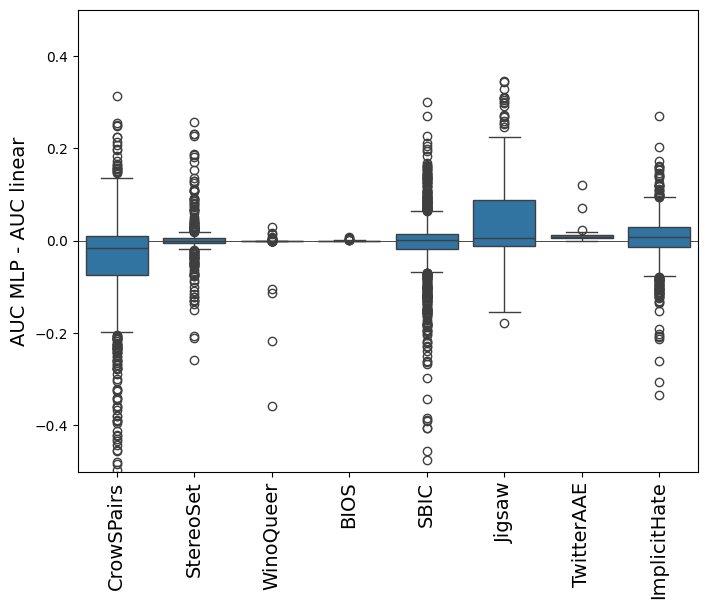



llama
[-] sign result for contrary Hyptohesis (MLP > lin):  -4.059538788291747 0.9999723404541121 0.010581177592304924
pythia


/tmp/ipykernel_344488/4215385229.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_diff = pd.concat([df_diff, new_rows], ignore_index=True)


[-] sign result for contrary Hyptohesis (MLP > lin):  -3.166143763491281 0.9991829442084608 0.008383535956323296
xlnet
[-] sign result for contrary Hyptohesis (MLP > lin):  -2.8265815786055 0.9975136332164352 0.008641121937942642
deepseek
~~ no sign results  -1.306096828365275 0.9038482526101439 0.006268977110008123
opt
[+] sign result (lin > MLP):  2.4304313068381713 0.00778783442763724 -0.007091897200574071
albert
~~ no sign results  0.513596398523426 0.3040491506656848 -0.0030148534309440422
text-emb.
[+] sign result (lin > MLP):  10.454421613787082 1.4605969246301536e-22 -0.0818782895465377
roberta
[+] sign result (lin > MLP):  6.178801034584635 7.212904302403076e-10 -0.02702878911074824
bert
[+] sign result (lin > MLP):  4.0531731319270055 3.2879602797194614e-05 -0.01737175821961917
deberta
[-] sign result for contrary Hyptohesis (MLP > lin):  -5.181859186468338 0.9999998126799616 0.019435075788897804
distilbert
[+] sign result (lin > MLP):  3.5298346104025122 0.000315112382078127

/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)


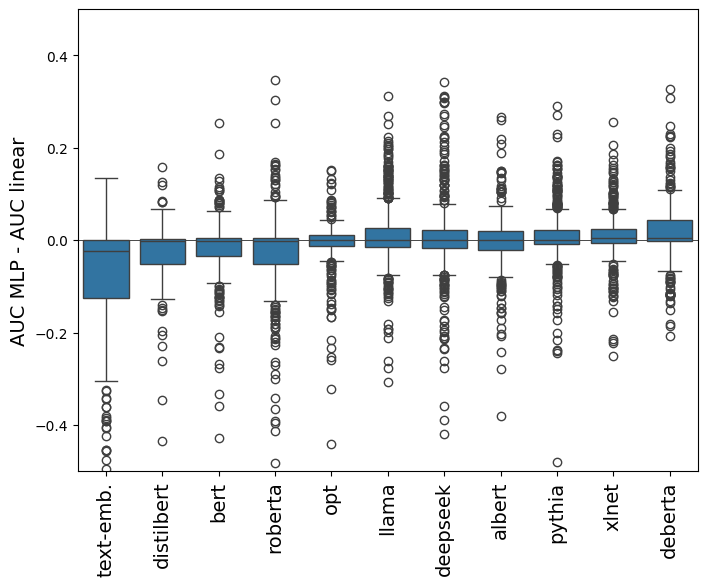



EleutherAI/pythia-410m
[-] sign result for contrary Hyptohesis (MLP > lin):  -4.759356921665726 0.9999979746676929 0.024422848699657995
xlnet/xlnet-large-cased


/tmp/ipykernel_344488/4215385229.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_diff = pd.concat([df_diff, new_rows], ignore_index=True)


[-] sign result for contrary Hyptohesis (MLP > lin):  -2.891198718817192 0.9978378084442744 0.014495206292868434
deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B
~~ no sign results  0.4713373901161615 0.3189901266661729 -0.0019219684572571727
meta-llama/Llama-3.2-3B
~~ no sign results  -0.6505849001762274 0.7419209542019672 0.0029957881330631153
text-embedding-3-small
[+] sign result (lin > MLP):  6.004802789927487 5.972972204049014e-09 -0.059501543513996946
text-embedding-3-large
[+] sign result (lin > MLP):  8.76478553551728 1.2109726956800475e-15 -0.10452959688009106
roberta-large
[+] sign result (lin > MLP):  4.16083343906877 2.4816899936720546e-05 -0.03131318298728458
deepseek-ai/deepseek-llm-7b-chat
~~ no sign results  -0.9197691191213486 0.8200682419045632 0.010795266625360567
meta-llama/Llama-3.2-3B-Instruct
~~ no sign results  -2.0653360264327083 0.9798256149468516 0.008637904893033344
distilbert-base-uncased
[+] sign result (lin > MLP):  3.5298346104025122 0.00031511238207812764 -0.

/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)


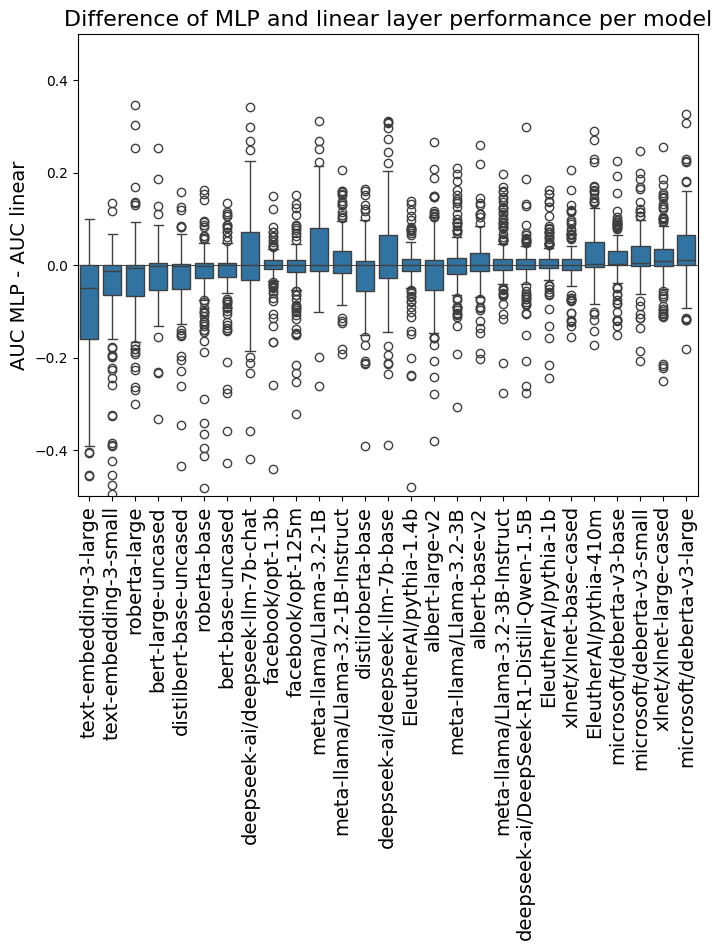



overweight
~~ no sign results  0.25069426654963445 0.40162226864190115 -0.003408316201793715
violence victims


/tmp/ipykernel_344488/4215385229.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_diff = pd.concat([df_diff, new_rows], ignore_index=True)


[-] sign result for contrary Hyptohesis (MLP > lin):  -2.4418590494061507 0.9920470957190768 0.008966827112907444
fit
~~ no sign results  0.8642490717652245 0.19767736174755063 -0.01658363373520272
mental_disorder
pearson correlation of group ratios and auc diff (mlp-lin):  -0.6210883312250676 9.666467768955365e-09
[+] sign result (lin > MLP):  3.2117981830243627 0.0010024226907234695 -0.07014155133757832
latino
[+] sign result (lin > MLP):  3.1901635682573137 0.001903295852871676 -0.04451561927523162
blonde
[-] sign result for contrary Hyptohesis (MLP > lin):  -4.694071458651249 0.9998781032375442 0.0005554918564152648
physical_disability


/tmp/ipykernel_344488/380773767.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = stats.pearsonr(ratios, auc_lin-auc_mlp)


~~ no sign results  1.5557798898183652 0.06171649971032874 -0.013607701673199218
rich
[+] sign result (lin > MLP):  3.6055840921685194 0.0006479590332263091 -0.04580921477255839
indigenous
~~ no sign results  -0.30060781436321277 0.6162077552968463 0.0036702695673961894
pregnant
~~ no sign results  2.0100279390833666 0.03079997187353855 -0.028117692361925573
illness
~~ no sign results  -0.16654098751628788 0.5654901789094653 0.004107637067995773
pansexual
~~ no sign results  -1.0002409667433476 0.8364136654815273 0.0005593371672740766
immigrant
pearson correlation of group ratios and auc diff (mlp-lin):  -0.2876372607146035 0.004488011851084082
[+] sign result (lin > MLP):  2.810459904278519 0.0030040115527538327 -0.03445207472588879
young
~~ no sign results  0.7632947860788629 0.22380997926403595 -0.004118657852550112
mental_disability
pearson correlation of group ratios and auc diff (mlp-lin):  0.32596029638511936 0.0020631139883050833
[+] sign result (lin > MLP):  3.5002292127648102

/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)


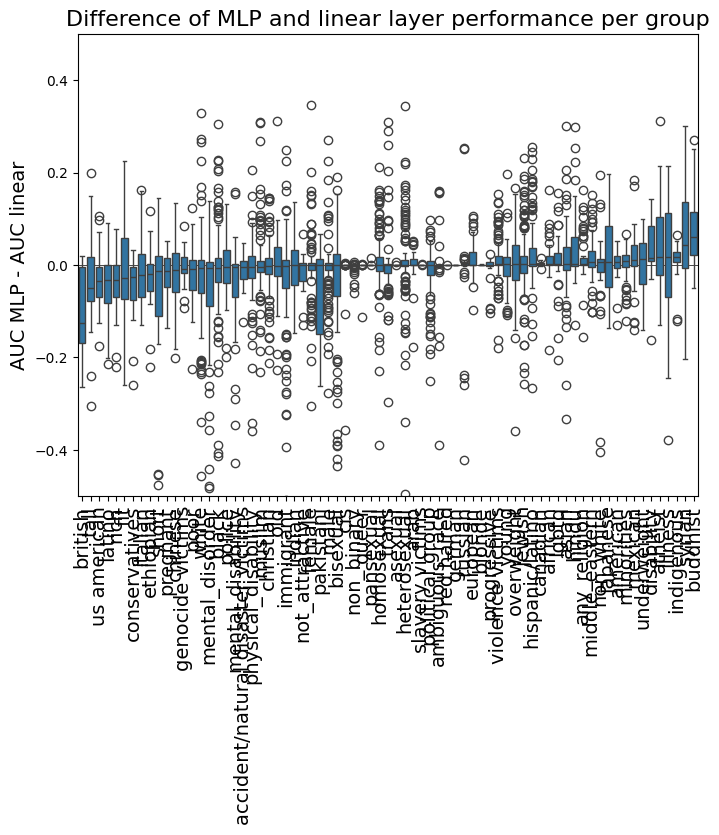

In [148]:
def ttest_per_param(df_lin, df_mlp, param_col, columns, plot_title, savefile=None):
    parameters = set(df_lin[param_col])

    df_diff = pd.DataFrame(columns=['param', 'diff'])
    for param in parameters:
        print(param)
        stat, pval, mean_lin, mean_mlp, diffs = run_ttest(df_mlp[df_mlp[param_col] == param], df_lin[df_lin[param_col] == param], columns)
        if pval < 0.01:
            print("[+] sign result (lin > MLP): ", stat, pval, mean_mlp-mean_lin)
        elif pval > 0.99:
            print("[-] sign result for contrary Hyptohesis (MLP > lin): ", stat, pval, mean_mlp-mean_lin)
        else:
            stat_, pval_, _, _, _ = run_ttest(df_lin[df_lin[param_col] == param], df_mlp[df_mlp[param_col] == param], columns, alternative='two-sided')
            if pval_ < 0.01:
               print("~~ two sided", mean_mlp-mean_lin)
            else:
                print("~~ no sign results ", stat, pval, mean_mlp-mean_lin)

        new_rows = pd.DataFrame({
            'param': [param] * len(diffs),
            'diff': diffs
        })
        df_diff = pd.concat([df_diff, new_rows], ignore_index=True)

    fig, ax = plt.subplots(figsize=(8,6))
    boxplot(df_diff, ax=ax, xcol='param', ycol='diff', huecol=None, title=plot_title, xlabel_rotation=90, fix_ylim=False, ymax=0.5, order=True)
    ax.set_ylabel('AUC MLP - AUC linear', fontsize=14)
    if savefile is not None:
        plt.savefig(savefile, bbox_inches='tight')
    plt.show()
        

ttest_per_param(df_lin, df_mlp, 'dataset', columns, plot_title='', savefile='../plots/auc_comp_datasets.eps')
print()
print()

ttest_per_param(df_lin, df_mlp, 'model type', columns, plot_title='', savefile='../plots/auc_comp_models.eps')
print()
print()

ttest_per_param(df_lin, df_mlp, 'model', columns, plot_title='Difference of MLP and linear layer performance per model')
print()
print()

ttest_per_param(df_lin, df_mlp, 'group_standardized', columns, plot_title='Difference of MLP and linear layer performance per group', savefile='../plots/auc_comp_groups.eps')

## Table with PR-AUC values

In [149]:
table = df.pivot_table(
    index=['model type', 'classifier'],
    columns='dataset',
    values='PR-AUC',
    aggfunc='first'  # oder z. B. 'mean'
)

# In LaTeX umwandeln
latex_table = table.to_latex(float_format="%.3f")
print(latex_table)

\begin{tabular}{llrrrrrrrr}
\toprule
 & dataset & BIOS & CrowSPairs & ImplicitHate & Jigsaw & SBIC & StereoSet & TwitterAAE & WinoQueer \\
model type & classifier &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{albert} & MLP2 & 0.997 & 0.346 & 0.146 & 0.412 & NaN & 0.779 & NaN & 1.000 \\
 & linear & 0.997 & 0.381 & 0.133 & 0.338 & 0.127 & 0.773 & NaN & 1.000 \\
\cline{1-10}
\multirow[t]{2}{*}{bert} & MLP2 & 1.000 & 0.399 & 0.173 & 0.456 & 0.171 & 0.843 & NaN & 1.000 \\
 & linear & 1.000 & 0.453 & 0.219 & 0.424 & 0.186 & 0.844 & NaN & 1.000 \\
\cline{1-10}
\multirow[t]{2}{*}{deberta} & MLP2 & 0.938 & 0.209 & 0.106 & 0.209 & 0.060 & 0.582 & 0.922 & 1.000 \\
 & linear & 0.933 & 0.191 & 0.076 & 0.079 & 0.049 & 0.565 & 0.917 & 1.000 \\
\cline{1-10}
\multirow[t]{2}{*}{deepseek} & MLP2 & 0.999 & 0.496 & 0.195 & 0.521 & 0.204 & 0.896 & 0.924 & 1.000 \\
 & linear & 0.999 & 0.509 & 0.227 & 0.514 & 0.199 & 0.885 & 0.910 & 1.000 \\
\cline{1-10}
\multirow[t]{2}{*}{distilbert} & MLP2 & 1.000 

## Boxplots

/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)
The PostScript backend does not support transparency; partially transpa

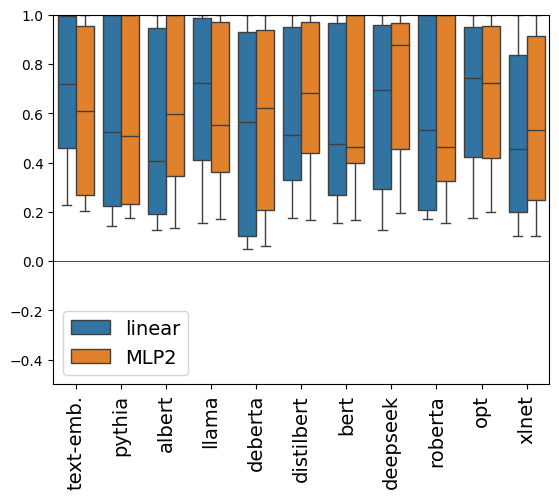

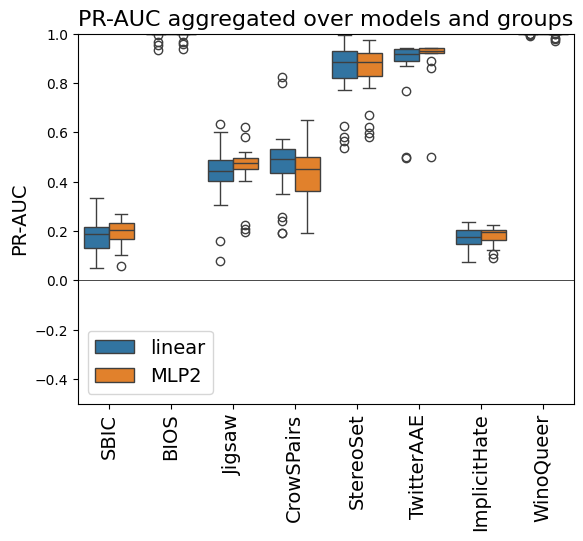

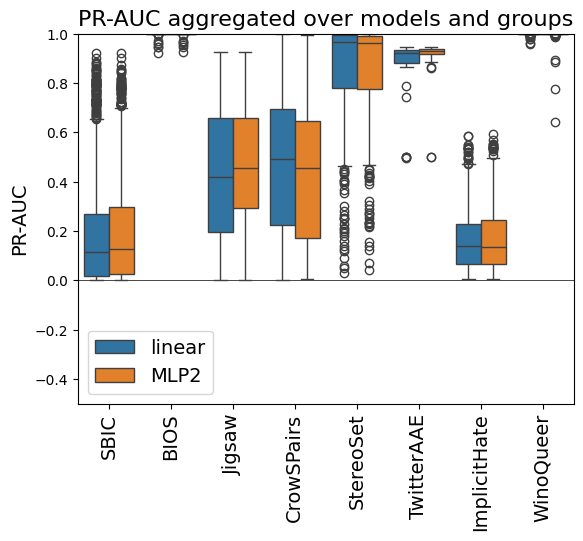

In [150]:
fig, ax = plt.subplots()
boxplot(df_mean, ax=ax, title='', xcol='model type', ycol='PR-AUC', huecol='classifier', remove_legend=False, xlabel_rotation=90)
plt.savefig('../plots/lin_mlp_per_model.eps', bbox_inches='tight')

fig, ax = plt.subplots()
boxplot(df_mean, ax=ax, title='PR-AUC aggregated over models and groups', xcol='dataset', ycol='PR-AUC', huecol='classifier', add_ylabel=True, remove_legend=False, xlabel_rotation=90)
plt.savefig('../plots/lin_mlp_per_dataset.eps', bbox_inches='tight')


fig, ax = plt.subplots()
boxplot(df_groups, ax=ax, title='PR-AUC aggregated over models and groups', xcol='dataset', ycol='PR-AUC', huecol='classifier', add_ylabel=True, remove_legend=False, xlabel_rotation=90)
plt.savefig('../plots/lin_mlp_per_dataset.eps', bbox_inches='tight')

/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)
/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)
/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)


Text(0.5, 1.0, 'Gender/ Sexual orientation')

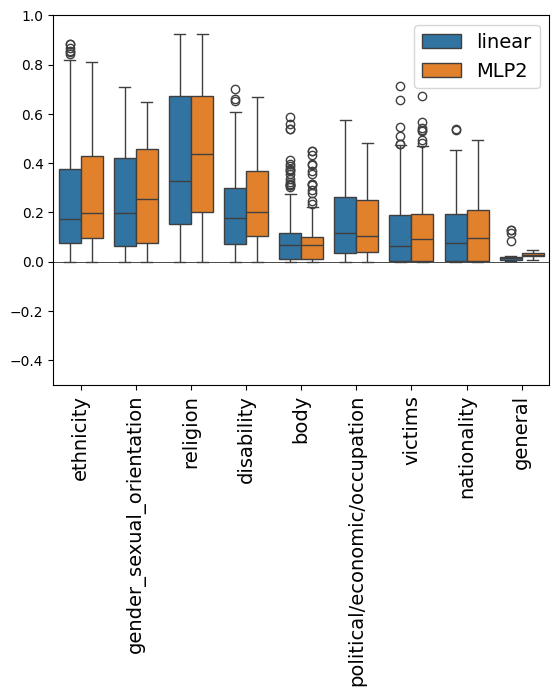

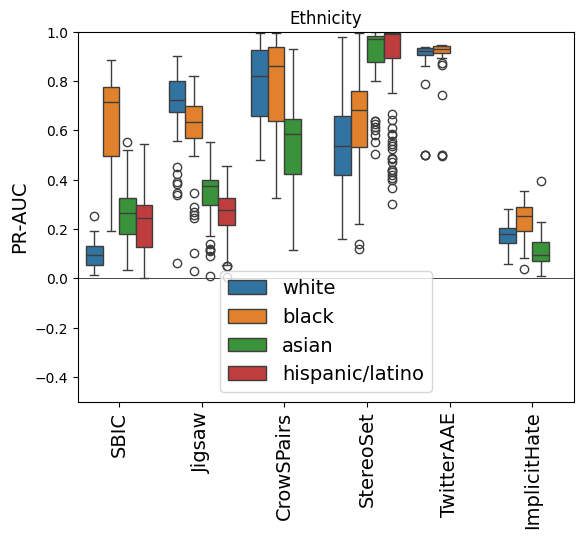

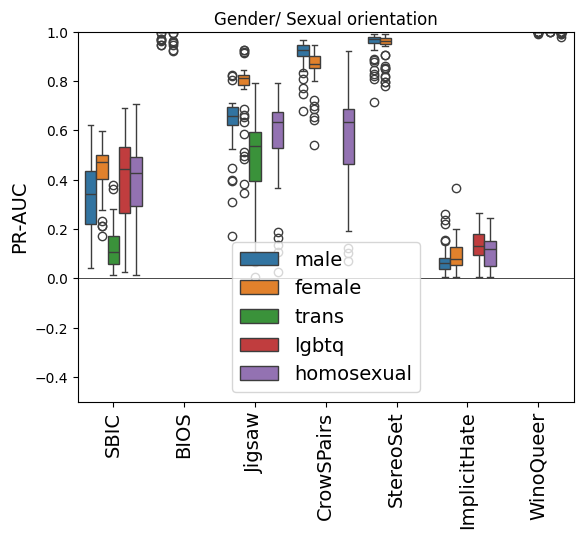

In [151]:
fig, ax = plt.subplots()
boxplot(df_groups[df_groups['dataset'] == 'SBIC'], ax=ax, title='', xcol='attribute', ycol='PR-AUC', huecol='classifier', remove_legend=False, xlabel_rotation=90)
#plt.savefig('../plots/lin_mlp_per_model.eps', bbox_inches='tight')

fig, ax = plt.subplots()
df_sel = df_groups[df_groups['attribute'] == 'ethnicity']
df_sel = df_sel[(df_sel['group_standardized'] == 'white') | (df_sel['group_standardized'] == 'black') | (df_sel['group_standardized'] == 'asian') | (df_sel['group_standardized'] == 'hispanic/latino')]
boxplot(df_sel, ax=ax, title='', xcol='dataset', ycol='PR-AUC', huecol='group_standardized', add_ylabel=True, remove_legend=False, xlabel_rotation=90)
ax.set_title('Ethnicity')
#plt.savefig('../plots/lin_mlp_per_dataset.eps', bbox_inches='tight')

fig, ax = plt.subplots()
df_sel = df_groups[df_groups['attribute'] == 'gender_sexual_orientation']
df_sel = df_sel[(df_sel['group_standardized'] == 'male') | (df_sel['group_standardized'] == 'female') | (df_sel['group_standardized'] == 'trans') | (df_sel['group_standardized'] == 'lgbtq') | (df_sel['group_standardized'] == 'homosexual')]
boxplot(df_sel, ax=ax, title='', xcol='dataset', ycol='PR-AUC', huecol='group_standardized', add_ylabel=True, remove_legend=False, xlabel_rotation=90)
ax.set_title('Gender/ Sexual orientation')
#plt.savefig('../plots/lin_mlp_per_dataset.eps', bbox_inches='tight')

In [115]:
df_groups

,Unnamed: 0,dataset,model,model type,architecture,pooling,classifier,clf hidden size factor,emb size,optimizer,...,loss,group,Pearson R,pvalue,PR-AUC,Epochs,attribute,group_standardized,group ratio,group samples
1,3,SBIC,text-embedding-3-small,text-emb.,embedder,unknown,linear,-1.0,1536,Salsa,...,BCEWithLogitsLoss,white,0.317888,4.304603e-236,0.193677,"[10, 10, 10, 10]",ethnicity,white,0.333955,120.0
2,4,SBIC,text-embedding-3-small,text-emb.,embedder,unknown,linear,-1.0,1536,Salsa,...,BCEWithLogitsLoss,black,0.767017,0.000000e+00,0.855652,"[10, 10, 10, 10]",ethnicity,black,8.312693,2987.0
3,5,SBIC,text-embedding-3-small,text-emb.,embedder,unknown,linear,-1.0,1536,Salsa,...,BCEWithLogitsLoss,asian,0.502718,0.000000e+00,0.497592,"[10, 10, 10, 10]",ethnicity,asian,1.775527,638.0
4,6,SBIC,text-embedding-3-small,text-emb.,embedder,unknown,linear,-1.0,1536,Salsa,...,BCEWithLogitsLoss,non-white,0.762215,0.000000e+00,0.851496,"[10, 10, 10, 10]",ethnicity,non_white,8.479670,3047.0
5,7,SBIC,text-embedding-3-small,text-emb.,embedder,unknown,linear,-1.0,1536,Salsa,...,BCEWithLogitsLoss,latin-american,0.435708,0.000000e+00,0.328526,"[10, 10, 10, 10]",ethnicity,hispanic/latino,0.116884,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9133,9917,WinoQueer,meta-llama/Llama-3.2-1B,llama,decoder,mean,MLP2,1.0,2048,Salsa,...,BCEWithLogitsLoss,Gay,1.000000,0.000000e+00,1.000000,"[10, 10, 10, 10]",gender_sexual_orientation,homosexual,5.935441,5406.0
9134,9918,WinoQueer,meta-llama/Llama-3.2-1B,llama,decoder,mean,MLP2,1.0,2048,Salsa,...,BCEWithLogitsLoss,Heterosexual,1.000000,0.000000e+00,1.000000,"[10, 10, 10, 10]",gender_sexual_orientation,heterosexual,16.214317,14768.0
9135,9919,WinoQueer,meta-llama/Llama-3.2-1B,llama,decoder,mean,MLP2,1.0,2048,Salsa,...,BCEWithLogitsLoss,Straight,0.999999,0.000000e+00,1.000000,"[10, 10, 10, 10]",gender_sexual_orientation,heterosexual,16.214317,14768.0
9136,9920,WinoQueer,meta-llama/Llama-3.2-1B,llama,decoder,mean,MLP2,1.0,2048,Salsa,...,BCEWithLogitsLoss,Cis,0.999994,0.000000e+00,1.000000,"[10, 10, 10, 10]",gender_sexual_orientation,cis,8.785683,8002.0


/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)
/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)
/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)
/tmp/ipykernel_344488/1532252649.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=xlabel_rotation)
/tmp/ipykernel_344488/1532252649.py:36: UserWarning:

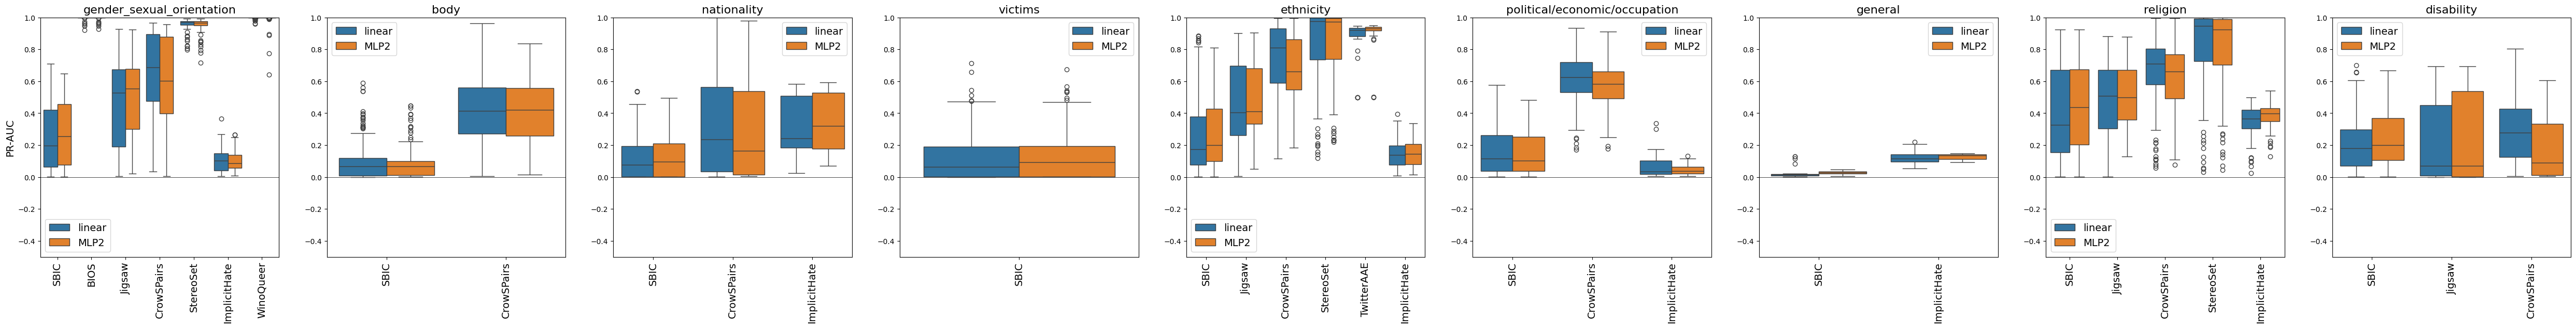

In [152]:
multiplot(df_groups, subplot_col='attribute', xcol='dataset', ycol='PR-AUC', huecol='classifier', title='', savefile=None, remove_legend=False, xlabel_rotation=90)

## Which combinations of models and datasets benefit most from MLP?

In [153]:
#df_mean['test'] = df_mean['dataset'] + ' x ' + df_mean['model']
df_mean_ = df_mean[(df_mean['dataset'] == 'Jigsaw') | (df_mean['dataset'] == 'SBIC') |  (df_mean['dataset'] == 'ImplicitHate')]
# TODO compute diff mlp-lin, sort by that and output models + scores

df_mean_lin = df_mean_[df_mean_['classifier'] == 'linear']
df_mean_mlp = df_mean_[df_mean_['classifier'] == 'MLP2']

match_columns = ['dataset', 'model', 'group']
sel_datasets = []
sel_models = []
lin_auc = []
mlp_auc = []
for i in range(len(df_mean_lin)):
    lin_row = df_mean_lin.iloc[i]
    mlp_matches = df_mean_mlp[df_mean_mlp.apply(lambda mlp_row: all(mlp_row[col] == lin_row[col] for col in match_columns), axis=1)]

    if len(mlp_matches) == 1:
        sel_datasets.append(lin_row['dataset'])
        sel_models.append(lin_row['model'])
        lin_auc.append(lin_row['PR-AUC'].squeeze())
        mlp_auc.append(mlp_matches['PR-AUC'].squeeze())

df_comp = pd.DataFrame({'dataset': sel_datasets, 'model': sel_models, 'AUC (linear)': lin_auc, 'AUC (MLP)': mlp_auc})

df_comp['diff'] = df_comp['AUC (MLP)'] - df_comp['AUC (linear)']
df_comp = df_comp.sort_values(by=['diff'])

df_comp[-10:]

,dataset,model,AUC (linear),AUC (MLP),diff
57,Jigsaw,meta-llama/Llama-3.2-3B-Instruct,0.452656,0.504482,0.051826
49,Jigsaw,microsoft/deberta-v3-small,0.159431,0.223037,0.063605
65,Jigsaw,roberta-large,0.401196,0.465021,0.063825
9,Jigsaw,albert-base-v2,0.337700,0.411650,0.073950
37,Jigsaw,EleutherAI/pythia-410m,0.412736,0.489419,0.076683
62,Jigsaw,deepseek-ai/deepseek-llm-7b-chat,0.403729,0.481183,0.077454
67,Jigsaw,meta-llama/Llama-3.2-1B,0.401878,0.489597,0.087719
47,Jigsaw,albert-large-v2,0.307474,0.402328,0.094854
39,Jigsaw,microsoft/deberta-v3-large,0.078533,0.197703,0.119170
54,Jigsaw,deepseek-ai/deepseek-llm-7b-base,0.315014,0.476628,0.161614


In [130]:
# in those cases where AUC MLP >> AUC linear, the MLP performance on par with other models, but linear is significantly worse -> rather pick another LM + linear classifier?
# but there is no significant correlation overall!
r, p = stats.pearsonr(df_comp["AUC (linear)"], df_comp["diff"])
print(f"Pearson r = {r:.3f}, p = {p:.3f}")

Pearson r = 0.071, p = 0.565


In [131]:
r, p = stats.pearsonr(df_comp["AUC (MLP)"], df_comp["diff"])
print(f"Pearson r = {r:.3f}, p = {p:.3f}")

Pearson r = 0.333, p = 0.005


## Check for group-specific effects

Plot by group ratio in the datasets and mark/colorize protected groups.

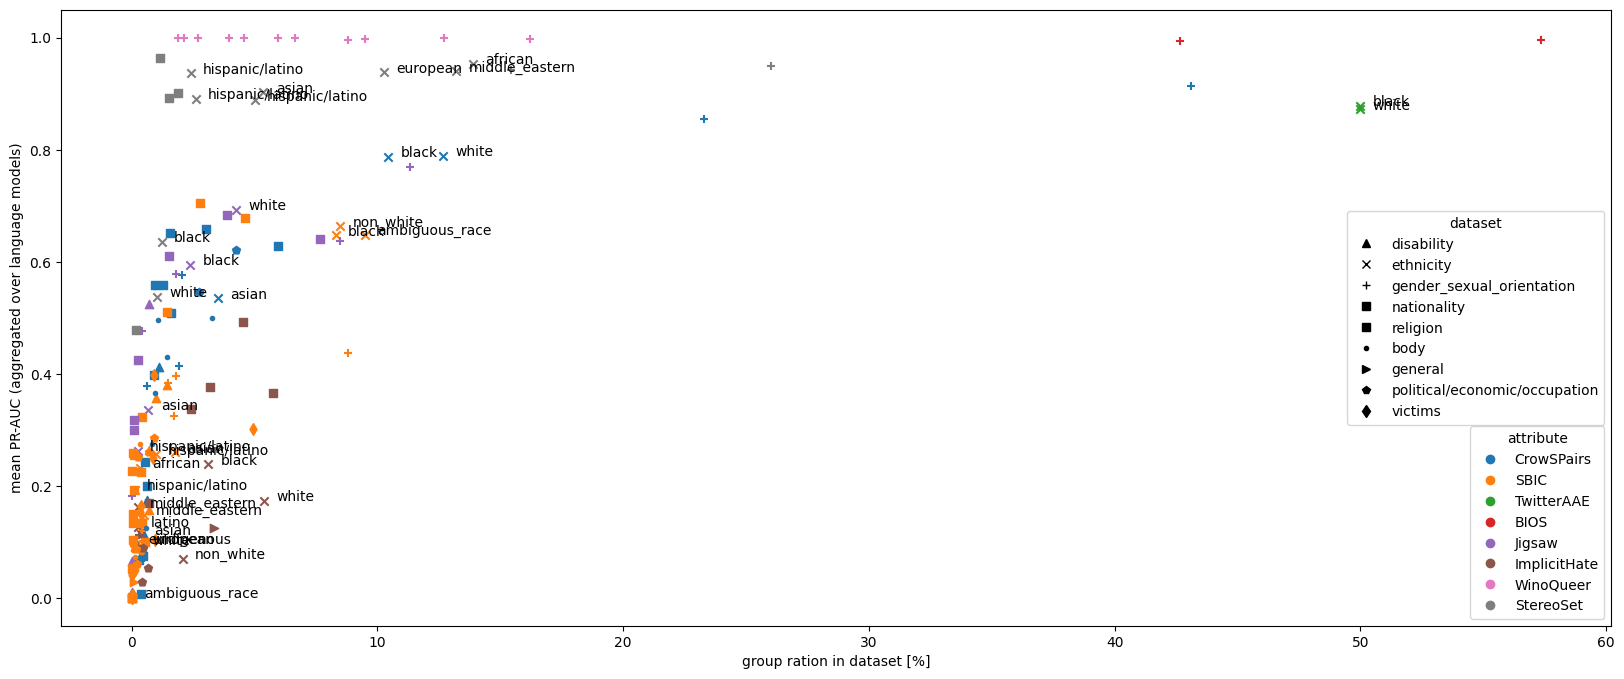

In [136]:
from matplotlib.lines import Line2D

datasets = list(set(df['dataset']))

tab_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {label: tab_colors[i % len(tab_colors)] for i, label in enumerate(datasets)}
dataset_marker = {'bios-supervised': '.', 'sbic': 's', 'stereoset': '+', 'crows_pairs': 'x', 'jigsaw': '^'}
attr_colors = {label: tab_colors[i % len(tab_colors)] for i, label in enumerate(protected_attr)}
attr_marker = {'disability': '^',
              'ethnicity': 'x',
              'gender_sexual_orientation': '+',
              'nationality': 's',
              'religion': 's',
              'body': '.',
              'general': '>',
              'political/economic/occupation': 'p',
              'victims': 'd'
         }

def plot_colored_marker(df, x_key, y_key, marker_key, color_key, marker_lookup, color_lookup, annotation_key, annotation_marker=None, annotate_cond_col=None):
    fig, ax = plt.subplots(figsize=(20,8))
    for key, mark in marker_lookup.items():
        df_mark = df[df[marker_key] == key]
        if annotate_cond_col is not None:
            agg = aggregate_results(df_mark, sel_cols=[color_key, x_key, annotation_key, annotate_cond_col], target_col=y_key)
        else:
            agg = aggregate_results(df_mark, sel_cols=[color_key, x_key, annotation_key], target_col=y_key)
        for ckey in set(agg[color_key]):
            agg_dataset = agg[agg[color_key] == ckey]
            ax.scatter(agg_dataset[x_key], agg_dataset[y_key], label=attr, color=color_lookup[ckey], marker=mark)
        
        if annotate_cond_col is not None:
            sel = agg[agg[annotate_cond_col] == 1]
            for i in sel.index:
                ax.text(sel.loc[i,x_key]+0.5, sel.loc[i,y_key], sel.loc[i, annotation_key])
        elif annotation_marker is not None and key==annotation_marker:
            for i in agg.index:
                ax.text(agg.loc[i,x_key]+0.5, agg.loc[i,y_key], agg.loc[i, annotation_key])
    
    
    color_handles = [
        Line2D([0], [0], color=color, marker='o', linestyle='', label=label)
        for label, color in color_lookup.items()
    ]
    marker_handles = [
        Line2D([0], [0], color='black', marker=marker, linestyle='', label=style)
        for style, marker in marker_lookup.items()
    ]
    
    legend1 = ax.legend(handles=color_handles, title=marker_key, loc='lower right')
    legend2 = ax.legend(handles=marker_handles, title=color_key, loc='center right')
    ax.add_artist(legend1)

    ax.set_xlabel('group ration in dataset [%]')
    ax.set_ylabel('mean PR-AUC (aggregated over language models)')
    
    plt.show()

plot_colored_marker(df_groups, marker_lookup=attr_marker, color_lookup=dataset_colors, x_key='group ratio', y_key='PR-AUC', marker_key='attribute', color_key='dataset', annotation_key='group_standardized', annotation_marker='ethnicity')

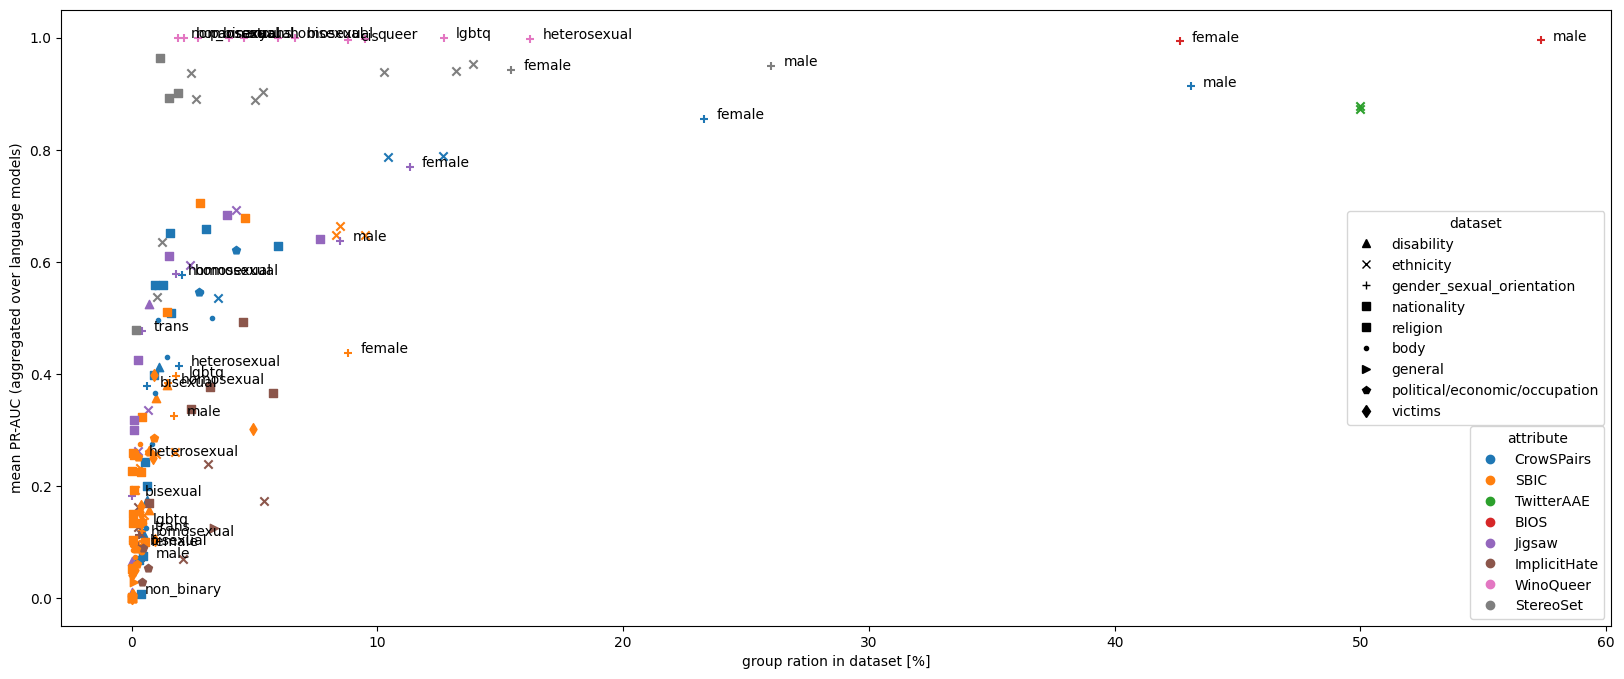

In [137]:
plot_colored_marker(df_groups, marker_lookup=attr_marker, color_lookup=dataset_colors, x_key='group ratio', y_key='PR-AUC', marker_key='attribute', color_key='dataset', annotation_key='group_standardized', annotation_marker='gender_sexual_orientation')